# __Neural Networks__
## Exam Project: Adversarial Training for Free!

**Students**:
- **Name**: *Gianmarco Scarano* | Matricola Code: *2047315*<br>
- **Name**: *Giancarlo Tedesco* | Matricola Code: *2057231*

**Todo**:
- Final polish of code (comments, etc)
- Time remaining translations
- Update ReadMe with pip installs
- How to use this code

### Google Colab compatibility
Run this next cell only if you're using Google Colab, otherwise make sure to have these installed!

In [ ]:
# Library needed for this notebook
!pip install -U tqdm gdown --quiet

# Imports

In [1]:
# We set the global variable for Google Colab, so we can assign possible paths, etc. accordingly
try:
  import google.colab
  RunningInCOLAB = True
except:
  RunningInCOLAB = False

In [2]:
import datetime
import time
import os
import random
import shutil
from collections import OrderedDict
from string import Formatter
from timeit import default_timer as timer

import gdown
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

print('Dependecies correctly loaded.')

Dependecies correctly loaded.


## Check if we have CUDA support

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060
Total memory: 12.0 GB


# Datasets

## Intel Image Classification

In [4]:
# We use the library gdown in order to download the IntelImageClassification Dataset from Google Drive.
# If downloadDataset = True, it will first clean up the directories and start downloading the dataset
# If downloadDataset = False, assumes that the dataset has already been downloaded
downloadDataset = True
datasetDirectory = "IntelImageClassification/"

if downloadDataset:
    try:
        shutil.rmtree(os.path.join(datasetDirectory))
        os.remove("IntelImageClassification.zip")
    except:
        print("Probably the dataset has already been cleaned up.")
        print("Re-downloading ...")

    Intel_Dataset_URL = 'https://drive.google.com/uc?id=' + '1cK4QSGd50LKb3pd-ZN8_3m0SwTCVodkC' + '&export=download&confirm=t' 
    gdown.download(Intel_Dataset_URL, 'IntelImageClassification.zip', quiet=False)
    print("Extracting dataset...")
    shutil.unpack_archive("IntelImageClassification.zip", datasetDirectory)

    # Cleaning files
    print("Cleaning files ...")

    os.remove("IntelImageClassification.zip")
    for dir in os.listdir(datasetDirectory):
        shutil.move(os.path.join(datasetDirectory, dir, dir), os.path.join(datasetDirectory,dir.split("_")[1]))
        shutil.rmtree(os.path.join(datasetDirectory, dir))
else:
    print("Dataset already downloaded.\nIf you want to re-download it, set the 'downloadDataset' variable to True!")

Dataset already downloaded.
If you want to re-download it, set the 'downloadDataset' variable to True!


In [5]:
# We instantiate the transformers variables, which resize and move our images to Tensors with value in range [0,1].
transformTrain = transforms.Compose([
    transforms.Resize((150,150)),
    #transforms.Normalize(mean=[0.4296, 0.4569, 0.4533], std=[0.2352, 0.2342, 0.2426]),
    transforms.ToTensor()
])

transformTest = transforms.Compose([
    transforms.Resize((150,150)),
    #transforms.Normalize(mean=[0.4300, 0.4554, 0.4521], std=[0.2343, 0.2328, 0.2414]),
    transforms.ToTensor()
])

In [6]:
train_path = 'IntelImageClassification/train'
test_path = 'IntelImageClassification/test'

train_dataset = datasets.ImageFolder(train_path, 
                               transform=transformTrain)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=32,
                                         shuffle=True,
                                         drop_last=True)
  
test_dataset = datasets.ImageFolder(test_path, 
                               transform=transformTest)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=32,
                                              shuffle=False,
                                              drop_last=True)

In [7]:
# Input size of the image divided into 3 variables
in_channels, width, height = train_dataset[0][0].size()

print(F"Width: {width}")
print(F"Height: {height}")
print(F"Channels: {in_channels}")
print("-----------------------------")
# Class names
print(F"Class names: {train_dataset.classes}")
num_classes = len(train_dataset.classes)
print(F"Number of classes: {num_classes}")
print("-----------------------------")
# Number of samples for training / validation set
print(F"Number of samples for training set: {len(train_dataset)}")
print(F"Number of samples for validation set: {len(test_dataset)}")

datasetName = 'IntelImageClassification'

Width: 150
Height: 150
Channels: 3
-----------------------------
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6
-----------------------------
Number of samples for training set: 14034
Number of samples for validation set: 3000


Image Size: torch.Size([32, 3, 150, 150])


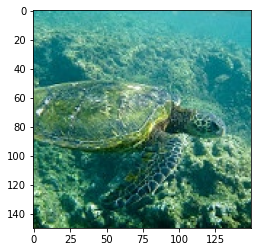

In [49]:
# Data visualization
images, labels = next(iter(train_loader))
image = images[0]

print(F"Image Size: {images.shape}")

# Normalize image
image = image * 255
image = image.permute(1,2,0).numpy().astype(np.uint8)

plt.imshow(image)

## Fashion MNIST Dataset

In [282]:
# Data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)) # -> If we don't normalize with mean/std we have to do it after clamping!!!! Plus we have to clamp between 0 and 1.
])

In [283]:
# Download the train dataset
train_dataset = datasets.FashionMNIST(root ='./', train=True, download=True, transform=transform)

# Download the test dataset
test_dataset = datasets.FashionMNIST(root ='./', train=False, download=True, transform=transform)

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [284]:
# Input size of the image divided into 3 variables
in_channels, height, width = train_dataset[0][0].size()
print(F"Width: {width}")
print(F"Height: {height}")
print(F"Channels: {in_channels}")
print("-----------------------------")
# Class names
print(F"Class names: {train_dataset.classes}")
num_classes = len(train_dataset.classes)
print(F"Number of classes: {num_classes}")
print("-----------------------------")
# Number of samples for training / validation set
print(F"Number of samples for training set: {len(train_dataset)}")
print(F"Number of samples for validation set: {len(test_dataset)}")

datasetName = 'FashionMNIST'

Width: 28
Height: 28
Channels: 1
-----------------------------
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10
-----------------------------
Number of samples for training set: 60000
Number of samples for validation set: 10000


Image Size: torch.Size([32, 1, 28, 28])
Min: 0.0
Max: 1.0


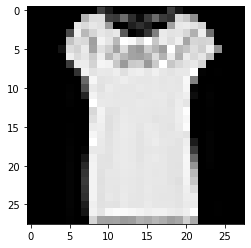

In [292]:
# Data visulization
images, labels = next(iter(train_loader))
image = images[2][0]

print(F"Image Size: {images.shape}")
print(F"Min: {image.min()}")
print(F"Max: {image.max()}")
plt.imshow(image, cmap='gray')

# Model definition: DummyNet

## DummyNet

In [10]:
class DummyNet(nn.Module):
    
    def __init__(self, num_classes=None, datasetName=None):
        super(DummyNet, self).__init__()
        
        if(num_classes == None):
            raise Exception(F"Please, provide a num_classes value!\nnum_classes is now: {num_classes}") 

        # First convolution
        if(datasetName == 'IntelImageClassification'):
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, device=device)
        else:
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, device=device)
    
        self.bn1 = nn.BatchNorm2d(32, device=device)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution       
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, device=device)
        self.bn2 = nn.BatchNorm2d(64, device=device)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        if(datasetName == 'IntelImageClassification'):     
            self.fc1 = nn.Linear(64 * 36 * 36, 600, device=device) # 64*36*36 is the output shape of the Flatten() function applied after the 2nd convolutional block.
        else:
            self.fc1 = nn.Linear(64 * 6 * 6, 600, device=device) # 64*6*6 is the output shape of the Flatten() function applied after the 2nd convolutional block.

        self.fc2 = nn.Linear(600, 120, device=device)
        self.fc3 = nn.Linear(120, num_classes, device=device)

        # Dropout Layer
        self.drop = nn.Dropout(p=0.25)
        
        # Activation functions
        self.relu = nn.ReLU()

        # Flatten layer
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x)))) # First convolution
        x = self.pool2(self.relu(self.bn2(self.conv2(x)))) # Second convolution

        x = self.flatten(x) # Flatten of the output of the 2nd convolutional block
        
        x = self.fc1(x)  # FC1
        x = self.drop(x) # Dropout
        x = self.fc2(x)  # FC2

        return self.fc3(x) # Final Layer -> We don't use SoftMax as CrossEntropyLoss already has it.

model = DummyNet(num_classes=num_classes, datasetName=datasetName)

## ResNet50

In [64]:
def resnet50():
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.required_grad = False

    inFeaturesFC = model.fc.in_features # We want to get the number of in_features of the FC layer

    model.fc = nn.Linear(inFeaturesFC, num_classes)
    
    return model.to(device)

model = resnet50()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training phase

## Training parameters

In [65]:
# Let's define some variables for the training phase
lr = 1e-2
momentum = 0.9
epochs = 100
startEpoch = 0

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Specify path for saving models
savePath = F'./save_path/{datasetName}/'
load_Checkpoint = False

## FreeAdversarial parameters
Epsilon: A common value for epsilon in image classification tasks when pixel values are in the range [0, 1] is 0.03. This corresponds to a maximum perturbation of 3% of the total pixel range.

Step size: The step size is typically chosen to be smaller than epsilon. A common value is 0.01, which corresponds to a step size of 1% of the total pixel range.

K: The value of K represents the number of iterations in the PGD attack. A larger value of K will result in a stronger attack but will also take longer to run. Common values for K are 7, 10, 20 or 40.

In [71]:
m = 5 # Usually it's a value m ≤ 10
freeEpochs = int(epochs / m)
epsilon = 0.03

batchNoise = None

# ---------- P G D ---------- #
K = 20
step_size = 0.01
epsilonPGD = 0.03

## Actual training phase

### Helper functions (Load-Save Checkpoints / Timers, etc.)

In [67]:
def loadCheckpoint(checkpointPath):   
        print("You specified a pre-loading directory for checkpoints.")
        if os.path.isfile(checkpointPath):
            print("=> Loading checkpoint '{}'".format(checkpointPath))
            checkpoint = torch.load(checkpointPath)

            # State & Optimizer
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            optimizer.load_state_dict(checkpoint['optimizer'])

            # Best validations
            try:
                best_val = checkpoint['best_val']
                print(F"\t- Best validation accuracy: {best_val:.4f}")
            except:
                print("\t- No best validation accuracy present in this model")
                best_val = 0.0
                pass

            try:
                best_pgd = checkpoint['best_pgd']
                print(F"\t- Best PGD validation accuracy: {best_pgd:.4f}")
            except:
                print("\t- No best PGD validation accuracy present in this model")
                best_pgd = 0.0
                pass

            # Starting epoch
            try:
                startEpoch = checkpoint['epoch']
                print(F"\t- Starting from epoch n.{startEpoch}")
            except:
                print("\t- No starting epoch present in this model")
                startEpoch = 0
                pass
            
            print("Checkpoint loaded successfully.")
        else:
            print("=> No checkpoint found at '{}'".format(checkpointPath))
            print("Are you sure the directory / checkpoint exist? Exiting..")
            exit(0)

        print("===================================================")
        return best_val, best_pgd, startEpoch

def loadModel(pathLoadModel, modelName):
        if(modelName == 'resnet50'):
            model = resnet50()
        elif(modelName == 'dummynet'):
            model = DummyNet(num_classes=num_classes, datasetName=datasetName)
        else:
            raise NotImplementedError("Specify a model!")

        if os.path.isfile(pathLoadModel):
            print("=> Loading model '{}'".format(pathLoadModel))
            modelLoaded = torch.load(pathLoadModel, device)

            # State
            model.load_state_dict(modelLoaded['state_dict'], strict=False)

            # Best accuracies
            try:
                bestVal = modelLoaded['best_val']
                print("\t- Best validation accuracy from model: {}".format(bestVal))
            except:
                bestVal = 0
                print("\t- No best validation accuracy present in this model")
                pass

            try:
                bestPgd = modelLoaded['best_pgd']
                print("\t- Best PGD validation accuracy from model: {}".format(bestPgd))
            except:
                bestPgd = 0
                print("\t- No best PGD validation accuracy present in this model")
                pass

            print("Custom model loaded successfully.")
        else:
            print("=> No model found at '{}'".format(pathLoadModel))
            print("Are you sure the directory / model exist? Exiting..")
            exit(0)

        print("===================================================")
        return model

def saveCheckpoint(state, is_best, savePath, epoch):
    if is_best:
        path = str(savePath) + '/best/' + 'model_best_epoch-{}.pth'.format(epoch)
    else:
        path = str(savePath)+'/checkpoint/' + 'checkpoint_epoch-{}.pth'.format(epoch)
    torch.save(state, path)

def strfdelta(tdelta, fmt='{D:02}d {H:02}h {M:02}m {S:02}s', inputtype='timedelta'):
    """Convert a datetime.timedelta object or a regular number to a custom-
    formatted string, just like the stftime() method does for datetime.datetime
    objects.
    The fmt argument allows custom formatting to be specified.  Fields can 
    include seconds, minutes, hours, days, and weeks.  Each field is optional.
    Some examples:
        '{D:02}d {H:02}h {M:02}m {S:02}s' --> '05d 08h 04m 02s' (default)
        '{W}w {D}d {H}:{M:02}:{S:02}'     --> '4w 5d 8:04:02'
        '{D:2}d {H:2}:{M:02}:{S:02}'      --> ' 5d  8:04:02'
        '{H}h {S}s'                       --> '72h 800s'
    The inputtype argument allows tdelta to be a regular number instead of the  
    default, which is a datetime.timedelta object.  Valid inputtype strings: 
        's', 'seconds', 
        'm', 'minutes', 
        'h', 'hours', 
        'd', 'days', 
        'w', 'weeks'
    """
    # Convert tdelta to integer seconds.
    if inputtype == 'timedelta':
        remainder = int(tdelta.total_seconds())
    elif inputtype in ['s', 'seconds']:
        remainder = int(tdelta)
    elif inputtype in ['m', 'minutes']:
        remainder = int(tdelta)*60
    elif inputtype in ['h', 'hours']:
        remainder = int(tdelta)*3600
    elif inputtype in ['d', 'days']:
        remainder = int(tdelta)*86400
    elif inputtype in ['w', 'weeks']:
        remainder = int(tdelta)*604800

    f = Formatter()
    desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]
    possible_fields = ('W', 'D', 'H', 'M', 'S')
    constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
    values = {}
    for field in possible_fields:
        if field in desired_fields and field in constants:
            values[field], remainder = divmod(remainder, constants[field])
    return f.format(fmt, **values)

def estimatedTime(singleTimeEpoch, i, totalEpochs, e, tempoTrascorso):

        epochRimanenti = totalEpochs - e

        if(epochRimanenti == 0):
            return 0

        if(i == 0):
            tempoSingoloEpoch = datetime.timedelta(seconds=singleTimeEpoch)
            tempoTrascorso = tempoSingoloEpoch

            nowDate = datetime.timedelta(seconds = datetime.datetime.now().timestamp())
            remainingTime = datetime.timedelta(seconds = ((nowDate + datetime.timedelta(seconds=tempoTrascorso.total_seconds() * epochRimanenti)).total_seconds()) - nowDate.total_seconds())

            print("- Tempo trascorso in media per un singolo epoch: {}".format(str(tempoTrascorso).split(".")[0]))
            print("- Orario di completamento stimato: {:%H:%M:%S del %d %B %Y} ({})".format(datetime.datetime.now() + datetime.timedelta(seconds=tempoTrascorso.total_seconds() * epochRimanenti), strfdelta(remainingTime,"{D:02} giorni, {H:02} ore, {M:02} minuti rimanenti")))
        else:
            tempoSingoloEpoch = datetime.timedelta(seconds=singleTimeEpoch)
            tempoTrascorso = tempoTrascorso + tempoSingoloEpoch
            temp = datetime.timedelta(seconds=tempoTrascorso.total_seconds() / (i + 1))

            nowDate = datetime.timedelta(seconds = datetime.datetime.now().timestamp())

            remainingTime = datetime.timedelta(seconds = ((nowDate + datetime.timedelta(seconds=temp.total_seconds() * epochRimanenti)).total_seconds()) - nowDate.total_seconds())

            print("- Tempo trascorso in media per un singolo epoch: {}".format(str(temp).split(".")[0]))
            print("- Orario di completamento stimato: {:%H:%M:%S del %d %B %Y} ({})".format(datetime.datetime.now() + datetime.timedelta(seconds=temp.total_seconds() * epochRimanenti), strfdelta(remainingTime,"{D:02} giorni, {H:02} ore, {M:02} minuti rimanenti")))
        return tempoTrascorso

### Helper methods (PGD Attack / Standard validation)

In [68]:
def pgdAttack(model, test_loader, criterion, K, step_size):

    correctPDG = 0
    totalPDG = 0
    totalLoss = 0
    show = False
    
    model.eval()

    for i, (input, labels) in enumerate(tqdm(test_loader, desc=F"- Validation PGD-{K}")):
        input = input.to(device=device)
        labels = labels.to(device=device)
        
        x = input.clone() # We save our original image
        x = x.to(device=device)

        # Apply a random initial noise with a Uniform between -epsilon & epsilon
        x = x + torch.zeros_like(x).uniform_(-epsilonPGD, epsilonPGD)
        j = 0
        
        for j in range(K):
            x.requires_grad_()

            with torch.enable_grad():
                logits = model(x)
                loss = criterion(logits, labels)

            # Compute the gradients w.r.t to the image
            xGrad = torch.autograd.grad(loss, x)[0]

            # Apply purturbation
            x = x + epsilonPGD * torch.sign(xGrad)

            # Workaround as PyTorch doesn't have elementwise clip
            # This is to ensure that the attacked image still stayes in the range of the epsilonPGD-value when we add perturbation

            # torch.max = Clip the minimum value of the input to be at least original image - epsilonPGD
            # torch.min = Clip the maximum value of the input to be at most original image + epsilonPGD
            x = torch.min(torch.max(x, input - epsilonPGD), input + epsilonPGD)
            x = torch.clamp(x, 0, 1)

            # === FOR TESTING ONLY ===
            if j == K-1 and i == len(test_loader)-1 and show == False:
                idx = random.randint(0, 15)
                adversarialExample = x[idx].cpu()
                adversarialExampleOrigin = input[idx].cpu()
                show = True
            # ========================

        adv_outputs = model(x)
        lossVal = criterion(adv_outputs, labels)

        # Make predictions on the adversarial images    
        _, predicted = torch.max(adv_outputs.data, 1)
        totalPDG += labels.size(0)
        correctPDG += (predicted == labels).sum().item()
        totalLoss += lossVal.item() * labels.size(0)

    accuracyVal = correctPDG / totalPDG
    lossVal = totalLoss / totalPDG

    return accuracyVal, lossVal, adversarialExample, adversarialExampleOrigin

In [69]:
def normalValidation(model, test_loader, criterion):

    correctVal = 0
    total = 0
    totalLoss = 0

    model.eval()
    
    # Normal evaluation
    with torch.no_grad():

        for valImg, labels in tqdm(test_loader, desc=F"- Validation"):
            
            valImg = valImg.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(valImg)

            lossVal = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correctVal += (predicted == labels).sum().item()
            totalLoss += lossVal.item() * labels.size(0)

        return correctVal / total, totalLoss / total

### Normal training

Here you can decide to load a checkpoint by simply running this next cell. <br>
Ignore if you want to start from scratch.

In [96]:
load_Checkpoint = True
checkpointPath = './save_path/IntelImageClassification/best/model_best_epoch-3.pth' # path to the .pth file

In [ ]:
print("---- STARTING NORMAL TRAINING ----")

print("===================================================")
print(F"The directory for saving checkpoints/models is: {savePath}")
if not(os.path.exists(os.path.join(savePath, 'checkpoint'))):
    os.makedirs(os.path.join(savePath, 'checkpoint'))

if not(os.path.exists(os.path.join(savePath, 'best'))):
    os.makedirs(os.path.join(savePath, 'best'))
print("===================================================")

best_val = 0.0
best_pgd = 0.0
p = 0

if (load_Checkpoint):
    best_val, best_pgd, startEpoch = loadCheckpoint(checkpointPath)

timePassed = datetime.timedelta(seconds=0)

# Train the model
for epoch in range(startEpoch, epochs):

    start = 0
    end = 0
    start = timer()

    correct = 0
    totalLab = 0
    total = 0

    model.train()
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=F"Epoch n.{epoch+1} (Train)")): # 4: for minibatch B ⊂ X do

        # We need to move to the GPU otherwise PyTorch will give issues when adding noise_batch to images
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        totalLab += labels.size(0)

    accuracy = correct / totalLab

    # Test the model
    model.eval()

    # Normal validation on the test set
    acc_val, loss_val = normalValidation(model, test_loader, criterion)

    # PGD Evaluation on the test set
    #acc_pgd, loss_pgd, adversarialExample, adversarialExampleOrigin = pgdAttack(model, test_loader, criterion, K=K, step_size=step_size)

    #if(acc_val > best_val and acc_pgd > best_pgd):
    if(acc_val > best_val):
        is_best = True
        bestEpoch = epoch + 1
        best_val = acc_val
        #best_pgd = acc_pgd
    else:
        is_best = False

    saveCheckpoint(state={
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'best_val': acc_val,
                    #'best_pgd': acc_pgd
                }, 
                is_best=is_best, 
                savePath=savePath, 
                epoch=epoch + 1)

    if(is_best):
        print(f'Epoch {epoch+1:03} (Best):')
    else:
        print(f'Epoch {epoch+1:03}:')
    print(f'\t- Training accuracy   : {accuracy:.4f}')
    print(f'\t- Training loss       : {loss.item():.4f}')
    print(f'\t- Validation accuracy : {acc_val:.4f} (Best: {best_val:.4f} / Epoch n.{bestEpoch})')
    print(f'\t- Validation loss : {loss_val:.4f}')
    #print(f'\t- Validation accuracy PGD : {acc_pgd:.4f} (Best: {best_pgd:.4f} / Epoch n.{bestEpoch})')
    #print(f'\t- Validation loss PGD : {loss_pgd:.4f}')
    print("=========================================")
    end = timer()
    timePassed = estimatedTime(end-start, p, epochs, epoch+1, timePassed)
    p += 1

### Free Adversarial Training

Here you can decide to load a checkpoint by simply running this next cell. <br>
Ignore if you want to start from scratch.

In [ ]:
load_Checkpoint = True
checkpointPath = '' # path to the .pth file

In [ ]:
print("---- STARTING FREE ADV TRAINING ----")

print("===================================================")
print(F"The directory for saving checkpoints/models is: {savePath}")
if not(os.path.exists(os.path.join(savePath, 'checkpoint'))):
    os.makedirs(os.path.join(savePath, 'checkpoint'))

if not(os.path.exists(os.path.join(savePath, 'best'))):
    os.makedirs(os.path.join(savePath, 'best'))
print("===================================================")

saveInput = False
best_val = 0.0
best_pgd = 0.0
p = 0

if (load_Checkpoint):
    best_val, best_pgd, startEpoch = loadCheckpoint(checkpointPath)
    
timePassed = datetime.timedelta(seconds=0)

# Train the model
for epoch in range(startEpoch, freeEpochs): # 3: for epoch = 1 . . . Nep/m do
    
    start = 0
    end = 0
    start = timer()

    correct = 0
    totalLab = 0
    total = 0

    # Instead of initializing delta to be a zero-like tensor, we initialize it with a Uniform between -0.1 and 0.1
    delta = torch.Tensor(32, in_channels, width, height).uniform_(-0.1, 0.1).to(device=device)
    
    model.train()
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=F"Epoch n.{epoch+1} (Train)")): # 4: for minibatch B ⊂ X do

        # We need to move to the GPU otherwise PyTorch will give issues when adding noise_batch to images
        images = images.to(device=device)
        labels = labels.to(device=device)
        j = 0
        
        for j in range(m): # 5: for i = 1 . . . m do

            editedInput = images.clone()
            editedInput.requires_grad = True

            # We want our model to not be trained on simple images but on images with noise δ (delta)
            batchNoise = delta[0:images.size(0)]
            batchNoise.to(device=device).requires_grad_(True)

            # === FOR TESTING ONLY ===
            if(saveInput):
                savedEditedInput = images.clone()
                saveInput = False
                
            if((epoch+1) == 3 and j == m-1):
                saveBatchNoise = batchNoise.clone()
                saveInput = True
            # ========================

            # So we add our noise to the image and we clip it between the min value of the original image and the max value of the original image
            editedInput = editedInput + batchNoise
            editedInput.clamp_(0, 1)

            # Forward pass
            outputs = model(editedInput)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward() # 7: gθ ← E(x,y)∈B[∇θ l(x + δ, y, θ)] ----> Plus we go popolate the batchNoise.grad value

            gadv = batchNoise.grad # 8: gadv ← ∇x l(x + δ, y, θ)] ---> We already computed this, we are just storing it in a variable

            optimizer.step() # 9: θ ← θ − τgθ

            # Update the delta tensor for the next j-iteration (we update the noise for the next set of images)
            delta[0:images.size(0)] = delta[0:images.size(0)] + (epsilon * torch.sign(gadv)) # 11: δ ← δ + eps · sign(gadv)
            
            delta[0:images.size(0)] = torch.clamp_(input=delta[0:images.size(0)], min=-epsilon, max=epsilon) # 12: δ ← clip(δ, -eps, eps)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            totalLab += labels.size(0)

    accuracy = correct / totalLab

    # Test the model
    model.eval()

    # Normal validation on the test set
    acc_val, loss_val = normalValidation(model, test_loader, criterion)

    # PGD Evaluation on the test set
    acc_pgd, loss_pgd, adversarialExample, adversarialExampleOrigin = pgdAttack(model, test_loader, criterion, K=K, step_size=step_size)

    if(acc_val > best_val and acc_pgd > best_pgd):
        is_best = True
        bestEpoch = epoch + 1
        best_val = acc_val
        best_pgd = acc_pgd
    else:
        is_best = False

    saveCheckpoint(state={
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'best_val': acc_val,
                    'best_pgd': acc_pgd
                }, 
                is_best=is_best, 
                savePath=savePath, 
                epoch=epoch + 1)

    print(f'Epoch {epoch+1:03}:')     
    print(f'\t- Training accuracy   : {accuracy:.4f}')
    print(f'\t- Training loss       : {loss.item():.4f}')
    print(f'\t- Validation accuracy : {acc_val:.4f} (Best: {best_val:.4f} / Epoch n. {bestEpoch})')
    print(f'\t- Validation loss : {loss_val:.4f}')
    print(f'\t- Validation accuracy PGD : {acc_pgd:.4f} (Best: {best_pgd:.4f} / Epoch n. {bestEpoch})')
    print(f'\t- Validation loss PGD : {loss_pgd:.4f}')
    print("=========================================")
    end = timer()
    timePassed = estimatedTime(end-start, p, freeEpochs, epoch+1, timePassed)
    p += 1

### Validation (for testing purposes)

#### Load a model

In [52]:
pathLoadModel = './save_path/IntelImageClassification/best/best_Intel_ResNet50_free2.pth' # path to the .pth file
modelName = 'resnet50' # If the .pth file was trained on resnet50 or on dummynet
model = loadModel(pathLoadModel, modelName)

=> Loading model './save_path/IntelImageClassification/best/best_Intel_ResNet50_free2.pth'
	- Best validation accuracy from model: 0.9025537634408602
	- Best PGD validation accuracy from model: 0.5413306451612904
Custom model loaded successfully.


#### Validate on Normal set and PGD set

- Validation PGD-40: 100%|██████████| 93/93 [07:02<00:00,  4.55s/it]


<Figure size 432x288 with 0 Axes>

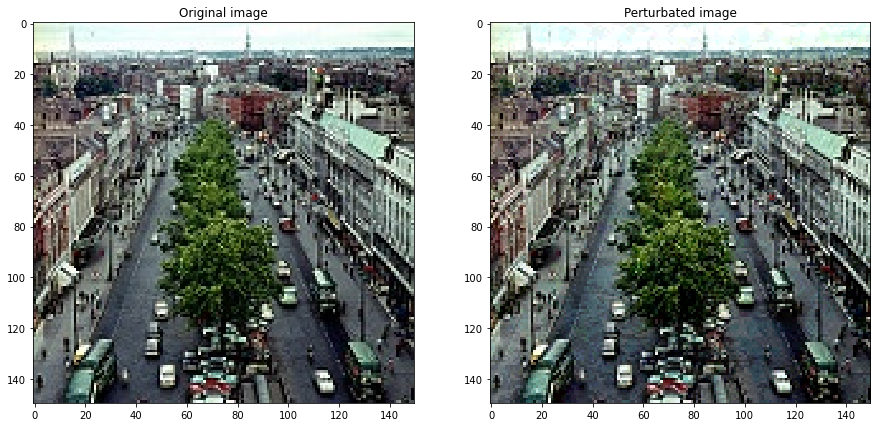

	- Validation accuracy : 0.9026
	- Validation loss : 0.5168
	- Validation accuracy PGD : 0.5397
	- Validation loss PGD : 3.1610


In [55]:
# We populate the K-value some cells above, in the "FreeAdversarial parameters" section, but through this variable
# we can easily modify the K-value for the PGD-K attack, so that you don't have to run again the section above.
#
# If you want to keep it at default, run the "FreeAdversarial parameters" section and leave this value 'K = K'
# Default: K = 20 (as per "FreeAdversarial parameters" section)
K = 40

# Normal validation on the test set
acc_val, loss_val = normalValidation(model, test_loader, criterion)

# PGD Evaluation on the test set
acc_pgd, loss_pgd, adversarialExample, adversarialExampleOrigin = pgdAttack(model, test_loader, criterion, K=K, step_size=step_size)

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

adversarialExampleOrigin = adversarialExampleOrigin * 255
adversarialExampleOrigin = adversarialExampleOrigin.permute(1,2,0).numpy().astype(np.uint8)

adversarialExample = adversarialExample * 255
adversarialExample = adversarialExample.permute(1,2,0).detach().numpy().astype(np.uint8)

axs[0].imshow(adversarialExampleOrigin, interpolation='nearest')
axs[0].set_title("Original image")
axs[1].imshow(adversarialExample, interpolation='nearest')
axs[1].set_title("Perturbated image")

plt.show()

print(f'\t- Validation accuracy : {acc_val:.4f}')
print(f'\t- Validation loss : {loss_val:.4f}')
print(f'\t- Validation accuracy PGD : {acc_pgd:.4f}')
print(f'\t- Validation loss PGD : {loss_pgd:.4f}')
print("=========================================")

### Show Free Adv Training in action (Original / Noise / Original + Perturbated)
We are able to show this starting from the training loop. <br>
Run the _Free Adversarial_ training loop for 4 epochs and the values will be populated.

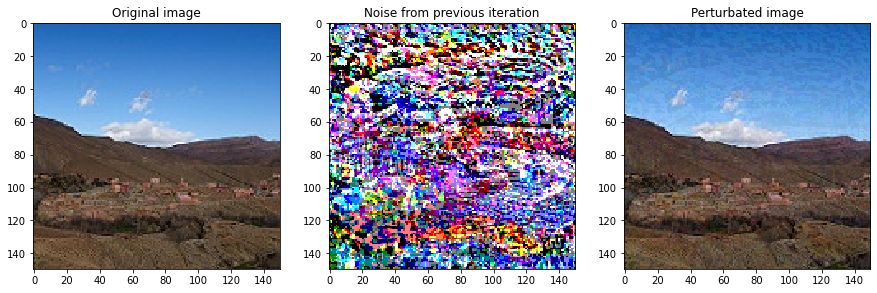

In [48]:
idx = random.choice(range(len(savedEditedInput)))

# Original
orig = savedEditedInput[idx].cpu()
orig = orig * 255

# Adv
adv = saveBatchNoise[idx].cpu()
adv = adv * 255

# Edited (original + adv)
orig_adv = orig + adv
orig_adv.clamp_(0, 255)

orig_grid = torchvision.utils.make_grid(orig.cpu().data, normalize=True)
adv_grid = torchvision.utils.make_grid(adv.cpu().data, normalize=True)
origadv_grid = torchvision.utils.make_grid(orig_adv.cpu().data, normalize=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

axs[0].imshow(orig_grid.permute(1, 2, 0), interpolation='nearest')
axs[0].set_title("Original image")
axs[1].imshow(adv_grid.permute(1, 2, 0), interpolation='nearest')
axs[1].set_title("Noise from previous iteration")
axs[2].imshow(origadv_grid.permute(1, 2, 0), interpolation='nearest')
axs[2].set_title("Perturbated image")

plt.show()

# The final results of our tests
###### Intel Image Classification-6 (L-inf epsilon=0.03 / epochs=100):
| Training | Natural Validation | PGD-7  | PGD-10 | PGD-20  | PGD-40 | Training Time (min) |
| -------- | ------------------ | ------ | ------ | ------- | ------ | --- |
| Natural  | 92.33              | 0.00   | 0.00   | 0.00    | 0.00   | 116 |
| Free-2   | 90.26              | 54.57  | 54.54  | 54.13   | 53.97  | 106 |
| Free-3   | 85.95              | 59.41  | 59.24  | 59.04   | 58.87  | 95  |
| Free-5   | 86.12              | 64.11  | 64.01  | 63.91   | 63.81  | 94  |
